In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [69]:
def create_submission(pred_A, pred_B, pred_C, output_file="submission.csv"):
    """
    Create a Kaggle submission file.

    Parameters:
    - pred_A, pred_B, pred_C: Arrays containing predictions.
    - output_file: Name of the output CSV file.

    Returns:
    - None. Writes the submission to a CSV file.
    """
    
    # Concatenate predictions
    predictions = np.concatenate([pred_A, pred_B, pred_C])

    # Create an id array
    ids = np.arange(0, len(predictions))

    # Create a DataFrame
    df = pd.DataFrame({
        'id': ids,
        'prediction': predictions
    })

    # Save to CSV
    df.to_csv(output_file, index=False)
    print(f"Submission saved to {output_file}")

In [1]:
# Read in the data
data_path = '../../preprocessing/data'

# For A
obs_A = pd.read_parquet(f'{data_path}/obs_A.parquet')
est_A = pd.read_parquet(f'{data_path}/est_A.parquet')
A = pd.concat([obs_A, est_A])

# For B
obs_B = pd.read_parquet(f'{data_path}/obs_B.parquet')
est_B = pd.read_parquet(f'{data_path}/est_B.parquet')
B = pd.concat([obs_B, est_B])

# For C
obs_C = pd.read_parquet(f'{data_path}/obs_C.parquet')
est_C = pd.read_parquet(f'{data_path}/est_C.parquet')
C = pd.concat([obs_C, est_C])

# For testing
test_A = pd.read_parquet(f'{data_path}/test_A.parquet').dropna()
test_B = pd.read_parquet(f'{data_path}/test_B.parquet').dropna()
test_C = pd.read_parquet(f'{data_path}/test_C.parquet').dropna()

print(test_A.columns)

NameError: name 'pd' is not defined

In [71]:
X_A = A.drop(columns=['pv_measurement'])
y_A = A['pv_measurement']

X_B = B.drop(columns=['pv_measurement'])
y_B = B['pv_measurement']

X_C = C.drop(columns=['pv_measurement'])
y_C = C['pv_measurement']


In [72]:
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# Split the data
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X_A, y_A, test_size=0.2, shuffle=False)

# Initialize XGBRegressor with the best parameters
xgb_A = XGBRegressor(
    subsample=0.85,
    reg_lambda=1.4,
    reg_alpha=0,
    n_estimators=550,
    min_child_weight=5,
    max_depth=8,
    learning_rate=0.01,
    gamma=0.2,
    colsample_bytree=0.7,
    random_state=0,
    booster='gbtree'
)

# Parameter grids
xgb_params = {
    'xgb__n_estimators': [500],
    'xgb__learning_rate': [0.01],
    'xgb__max_depth': [8],
    'xgb__subsample': [0.9],
    'xgb__colsample_bytree': [0.7],
    'xgb__gamma': [0.2],
    'xgb__min_child_weight': [5],
    'xgb__reg_alpha': [0.05],
    'xgb__reg_lambda': [1.5]
}

rf_params = {
    'rf__n_estimators': [150],
    'rf__max_depth': [None, 15, 25],
    'rf__min_samples_split': [10, 15],
    'rf__min_samples_leaf': [2, 10]
}

meta_params = {
    'final_estimator__fit_intercept': [True, False]
}

all_params = {**xgb_params, **rf_params, **meta_params}

# Initialize other models
rf_model = RandomForestRegressor(n_estimators=500, random_state=0)
meta_model = LinearRegression()

# Create the stacking model
stacked_model = StackingRegressor(
    estimators=[('xgb', xgb_A), ('rf', rf_model)],
    final_estimator=meta_model
)

# Define custom scoring function
def custom_score(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    print(f"Currently evaluating. MSE: {mse}")
    return mse

# Create custom scorer
custom_scorer = make_scorer(custom_score, greater_is_better=False)

# Initialize RandomizedSearchCV with custom scorer
random_search = RandomizedSearchCV(
    estimator=stacked_model,
    param_distributions=all_params,
    n_iter=20,
    cv=5,
    verbose=1,
    random_state=0,
    scoring=custom_scorer  # Use the custom scorer here
)

# Fit RandomizedSearchCV
print('Training the stacked model with RandomizedSearchCV...')
random_search.fit(X_train_A, y_train_A)

# Get Best Parameters
best_params = random_search.best_params_
print(f'Best Parameters: {best_params}')

# Make predictions with the best stacked model
best_stacked_model = random_search.best_estimator_
pred_A_stacked = best_stacked_model.predict(X_test_A)
pred_A_stacked = np.clip(pred_A_stacked, 0, None)




Training the stacked model with RandomizedSearchCV...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Currently evaluating. MSE: 232199.58302894825
Currently evaluating. MSE: 297318.1856494464
Currently evaluating. MSE: 121614.5863391542
Currently evaluating. MSE: 281122.54002552055
Currently evaluating. MSE: 205464.683870575
Currently evaluating. MSE: 232199.58302894825
Currently evaluating. MSE: 297318.1856494464
Currently evaluating. MSE: 121614.5863391542
Currently evaluating. MSE: 281122.54002552055
Currently evaluating. MSE: 205464.683870575
Currently evaluating. MSE: 232217.9878777352
Currently evaluating. MSE: 297439.3229151617
Currently evaluating. MSE: 121665.08222328135
Currently evaluating. MSE: 280998.356391082
Currently evaluating. MSE: 205464.70649661132
Currently evaluating. MSE: 232217.9878777352
Currently evaluating. MSE: 297439.3229151617
Currently evaluating. MSE: 121665.08222328135
Currently evaluating. MSE: 280998.356391082
Currently evaluating. MSE:

Mean Squared Error (MAE) of Stacked Model: 159062.95673278387


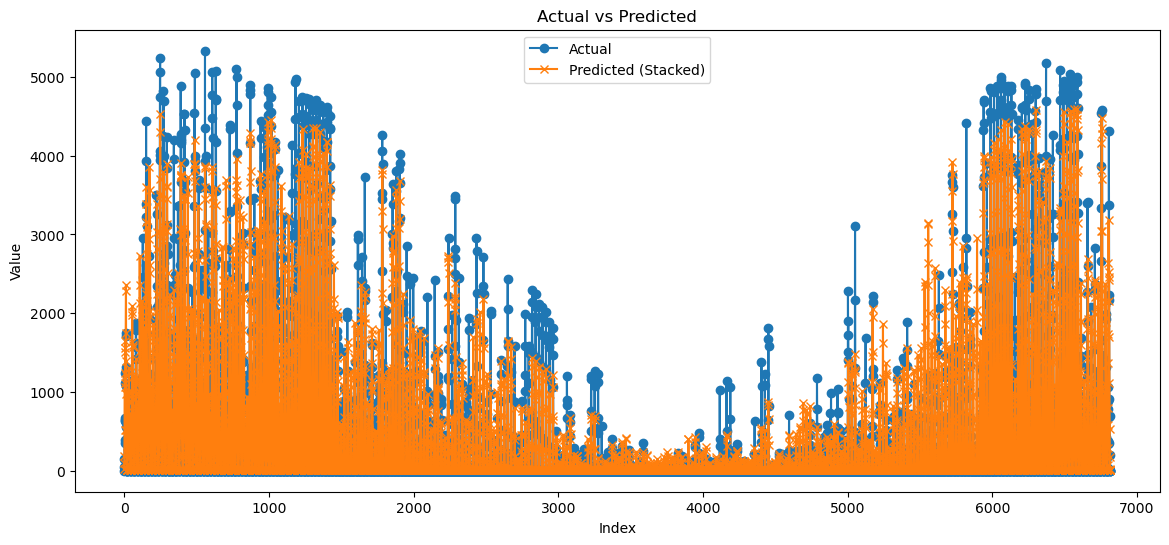

In [73]:
y_pred_A_test_stacked = best_stacked_model.predict(X_test_A)

# Calculate the Mean Absolute Error
mae_stacked = mean_squared_error(y_test_A, y_pred_A_test_stacked)
print("Mean Squared Error (MAE) of Stacked Model:", mae_stacked)

# Plotting
index = np.arange(len(y_test_A))
plt.figure(figsize=(14, 6))

# Plot actual values
plt.plot(index, y_test_A, label='Actual', marker='o')

# Plot predicted values from the stacked model
plt.plot(index, y_pred_A_test_stacked, label='Predicted (Stacked)', marker='x')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

Training the stacked model for B with RandomizedSearchCV...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters for Model B: {'xgb_B__subsample': 0.85, 'xgb_B__reg_lambda': 1.1, 'xgb_B__reg_alpha': 0.1, 'xgb_B__n_estimators': 450, 'xgb_B__min_child_weight': 1, 'xgb_B__max_depth': 7, 'xgb_B__learning_rate': 0.01, 'xgb_B__gamma': 0.15, 'xgb_B__colsample_bytree': 0.65, 'rf_B__n_estimators': 120, 'rf_B__min_samples_split': 2, 'rf_B__min_samples_leaf': 1, 'rf_B__max_depth': 10, 'final_estimator__fit_intercept': False}
Mean Absolute Error (MAE) of Stacked Model B: 38.810366817437114


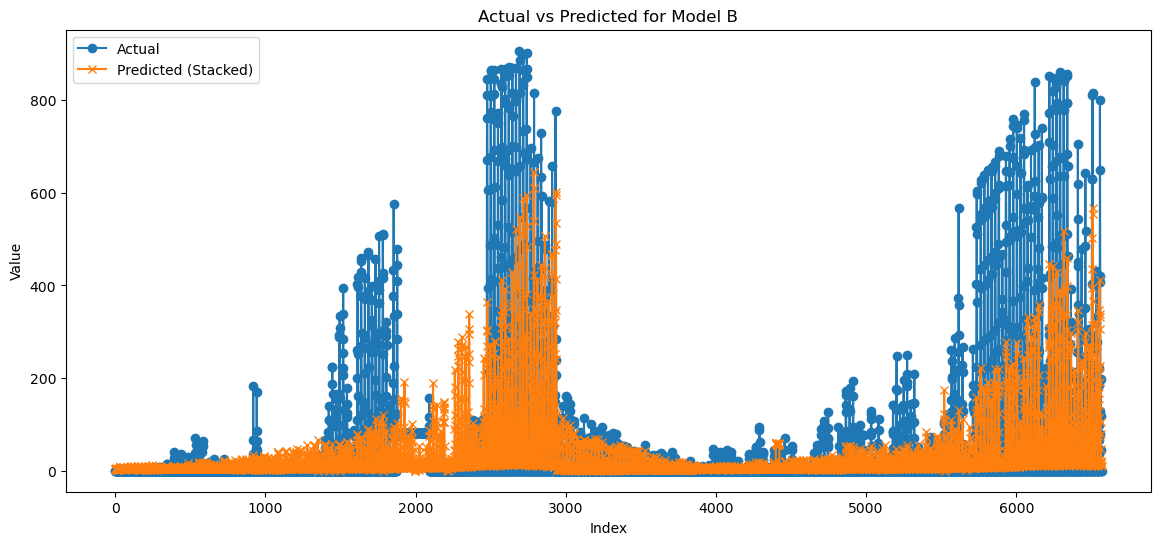

In [74]:
# Split the data
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_B, y_B, test_size=0.2, shuffle=False)

# Initialize XGBRegressor with the best parameters for model B
xgb_B = XGBRegressor(
    subsample=0.85,
    reg_lambda=1.1,
    reg_alpha=0.1,
    n_estimators=450,
    min_child_weight=0,
    max_depth=7,
    learning_rate=0.01,
    gamma=0.15,
    colsample_bytree=0.65,
    random_state=0,
    booster='gbtree'
)

# Parameter grids
xgb_params_B = {
    'xgb_B__n_estimators': [450],
    'xgb_B__learning_rate': [0.01],
    'xgb_B__max_depth': [7],
    'xgb_B__subsample': [0.85],
    'xgb_B__colsample_bytree': [0.65],
    'xgb_B__gamma': [0.15],
    'xgb_B__min_child_weight': [1],
    'xgb_B__reg_alpha': [0.1],
    'xgb_B__reg_lambda': [1.1]
}

rf_params_B = {
    'rf_B__n_estimators': [120, 180],
    'rf_B__max_depth': [None, 10, 20],
    'rf_B__min_samples_split': [2, 8],
    'rf_B__min_samples_leaf': [1, 3]
}

meta_params_B = {
    'final_estimator__fit_intercept': [True, False]
}

all_params_B = {**xgb_params_B, **rf_params_B, **meta_params_B}

# Initialize other models
rf_model_B = RandomForestRegressor(n_estimators=500, random_state=0)
meta_model_B = LinearRegression()

# Create the stacking model for model B
stacked_model_B = StackingRegressor(
    estimators=[('xgb_B', xgb_B), ('rf_B', rf_model_B)],
    final_estimator=meta_model_B
)

# Initialize RandomizedSearchCV
random_search_B = RandomizedSearchCV(
    estimator=stacked_model_B,
    param_distributions=all_params_B,
    n_iter=10,
    cv=5,
    verbose=1,
    random_state=0
)

# Fit RandomizedSearchCV
print('Training the stacked model for B with RandomizedSearchCV...')
random_search_B.fit(X_train_B, y_train_B)

# Get Best Parameters
best_params_B = random_search_B.best_params_
print(f'Best Parameters for Model B: {best_params_B}')

# Make predictions with the best stacked model for model B
best_stacked_model_B = random_search_B.best_estimator_
pred_B = best_stacked_model_B.predict(test_B)

y_pred_B_test_stacked = best_stacked_model_B.predict(X_test_B)
y_pred_B_test_stacked = np.clip(y_pred_B_test_stacked, 0, None)

# Calculate the Mean Absolute Error for model B
mae_stacked_B = mean_absolute_error(y_test_B, y_pred_B_test_stacked)
print("Mean Absolute Error (MAE) of Stacked Model B:", mae_stacked_B)

# Plotting for model B
index_B = np.arange(len(y_test_B))
plt.figure(figsize=(14, 6))

# Plot actual values for model B
plt.plot(index_B, y_test_B, label='Actual', marker='o')

# Plot predicted values from the stacked model for model B
plt.plot(index_B, y_pred_B_test_stacked, label='Predicted (Stacked)', marker='x')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted for Model B')
plt.legend()
plt.show()

Mean Absolute Error (MSE) of Stacked Model B: 9728.095746666155


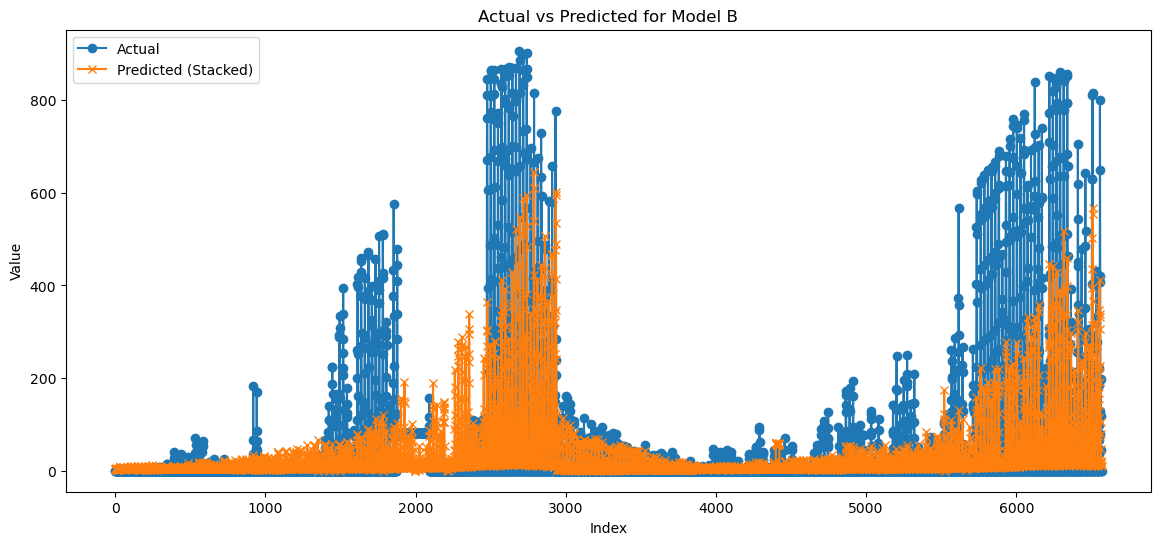

In [75]:
# Calculate the Mean Absolute Error for model B
mae_stacked_B = mean_squared_error(y_test_B, y_pred_B_test_stacked)
print("Mean Absolute Error (MSE) of Stacked Model B:", mae_stacked_B)

# Plotting for model B
index_B = np.arange(len(y_test_B))
plt.figure(figsize=(14, 6))

# Plot actual values for model B
plt.plot(index_B, y_test_B, label='Actual', marker='o')

# Plot predicted values from the stacked model for model B
plt.plot(index_B, y_pred_B_test_stacked, label='Predicted (Stacked)', marker='x')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted for Model B')
plt.legend()
plt.show()

In [76]:
# Split the data for model C
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(X_C, y_C, test_size=0.2, shuffle=False)

# Initialize XGBRegressor with the best parameters for model C
xgb_C = XGBRegressor(
    subsample=0.85,
    reg_lambda=1.1,
    reg_alpha=0.1,
    n_estimators=450,
    min_child_weight=0,
    max_depth=7,
    learning_rate=0.01,
    gamma=0.15,
    colsample_bytree=0.65,
    random_state=0,
    booster='gbtree'
)

# Parameter grids
xgb_params_C = {
    'xgb_C__n_estimators': [450],
    'xgb_C__learning_rate': [0.01],
    'xgb_C__max_depth': [7],
    'xgb_C__subsample': [0.85],
    'xgb_C__colsample_bytree': [0.65],
    'xgb_C__gamma': [0.15],
    'xgb_C__min_child_weight': [1],
    'xgb_C__reg_alpha': [0.1],
    'xgb_C__reg_lambda': [1.1]
}

rf_params_C = {
    'rf_C__n_estimators': [100, 180],
    'rf_C__max_depth': [None, 10, 25],
    'rf_C__min_samples_split': [2, 8],
    'rf_C__min_samples_leaf': [1, 3]
}

meta_params_C = {
    'final_estimator__fit_intercept': [True, False]
}

all_params_C = {**xgb_params_C, **rf_params_C, **meta_params_C}

# Initialize other models
rf_model_C = RandomForestRegressor(n_estimators=500, random_state=0)
meta_model_C = LinearRegression()

# Create the stacking model for model C
stacked_model_C = StackingRegressor(
    estimators=[('xgb_C', xgb_C), ('rf_C', rf_model_C)],
    final_estimator=meta_model_C
)

# Initialize RandomizedSearchCV
random_search_C = RandomizedSearchCV(
    estimator=stacked_model_C,
    param_distributions=all_params_C,
    n_iter=10,
    cv=4,
    verbose=1,
    random_state=0
)

# Fit RandomizedSearchCV
print('Training the stacked model for C with RandomizedSearchCV...')
random_search_C.fit(X_train_C, y_train_C)

# Get Best Parameters
best_params_C = random_search_C.best_params_
print(f'Best Parameters for Model C: {best_params_C}')

# Make predictions with the best stacked model for model C
best_stacked_model_C = random_search_C.best_estimator_
y_pred_C_test_stacked = best_stacked_model_C.predict(X_test_C)
y_pred_C_test_stacked = np.clip(y_pred_C_test_stacked, 0, None)



Training the stacked model for C with RandomizedSearchCV...
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Best Parameters for Model C: {'xgb_C__subsample': 0.85, 'xgb_C__reg_lambda': 1.1, 'xgb_C__reg_alpha': 0.1, 'xgb_C__n_estimators': 450, 'xgb_C__min_child_weight': 1, 'xgb_C__max_depth': 7, 'xgb_C__learning_rate': 0.01, 'xgb_C__gamma': 0.15, 'xgb_C__colsample_bytree': 0.65, 'rf_C__n_estimators': 180, 'rf_C__min_samples_split': 2, 'rf_C__min_samples_leaf': 3, 'rf_C__max_depth': 10, 'final_estimator__fit_intercept': False}


Mean Absolute Error (MSE) of Stacked Model C: 3948.17658161925


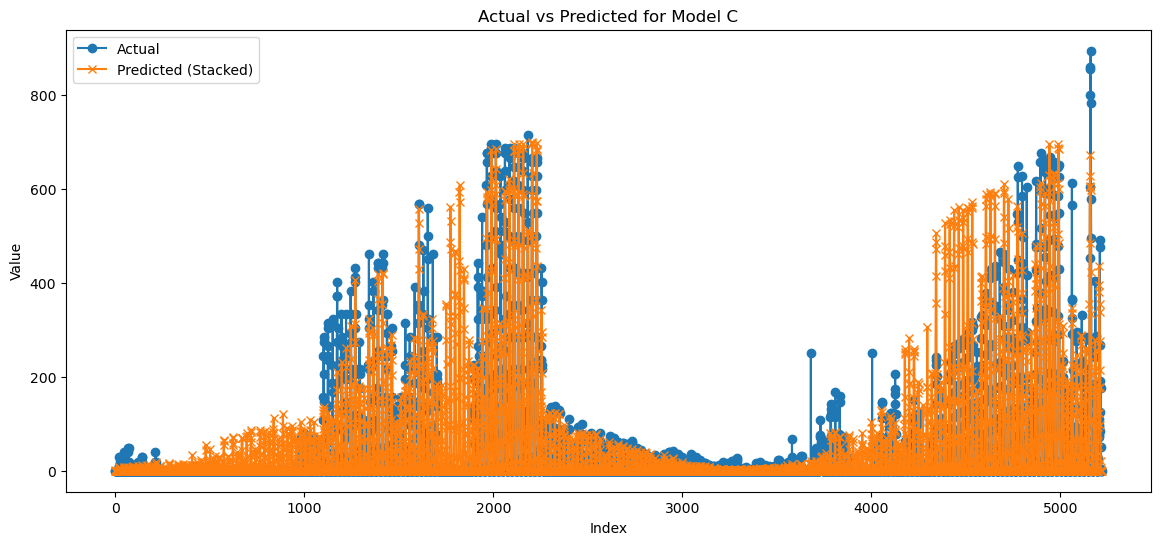

In [77]:
# Calculate the Mean Absolute Error for model C
mae_stacked_C = mean_squared_error(y_test_C, y_pred_C_test_stacked)
print("Mean Absolute Error (MSE) of Stacked Model C:", mae_stacked_C)

# Plotting for model C
index_C = np.arange(len(y_test_C))
plt.figure(figsize=(14, 6))

# Plot actual values for model C
plt.plot(index_C, y_test_C, label='Actual', marker='o')

# Plot predicted values from the stacked model for model C
plt.plot(index_C, y_pred_C_test_stacked, label='Predicted (Stacked)', marker='x')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted for Model C')
plt.legend()
plt.show()

In [78]:
pred_A = best_stacked_model.predict(test_A)
pred_B = best_stacked_model_B.predict(test_B)
pred_C = best_stacked_model_B.predict(test_C)


create_submission(pred_A, pred_B, pred_C, output_file="../../submission.csv")

Submission saved to ../../submission.csv
